### Summary, Modeling, and Prediction using Labeled Data

In this notebook, I merge Upworker-provided data labels into the existing merged_cleaned.csv dataset. I then show a series of brief descriptive graphics of the labeled data. 

I then turn to balancing techniques for this imbalanced data set. I then create and fit a pre-processing pipeline to transform data for classification algorithms, discuss and choose an appropriate evaluation metric, and fit a series of algorithms on the training set using 10-fold cross validation. I then select a model in light of interpretability concerns, tune model hyperparameters, and report the selected and tuned model's outcomes on my test set.

In [16]:
import sys
assert sys.version_info >= (3, 5)
import os

import sklearn
assert sklearn.__version__ >= "0.20"

import pandas as pd
import numpy as np
import nltk
from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Import Matplotlib and Seaborn
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

#Import helpful user-defined functions for directories in nb_functions.py
from nb_functions import set_project_root, change_dir

try:
    PROJECT_ROOT
except:
    PROJECT_ROOT = set_project_root()

#### 1. Summary of Labeled Data 

Below, I merge data labels (1) having an initial stance and (2) having a follow up using matching pre-assigned tweet_id values in a one-to-one merge. 

In [17]:
# Read in the labels and tweet_id column for matching, concatenate into one dataset
change_dir(PROJECT_ROOT, '/data/upwork_rater_data') 
col_names = ['floyd_stance','floyd_followup','tweet_id']
df_1 = pd.read_csv('df_u_1_a.csv', usecols=col_names)
df_2 = pd.read_csv('df_u_2_a.csv', usecols=col_names)
df_3 = pd.read_csv('df_u_3_a.csv', usecols=col_names)
df_4 = pd.read_csv('df_u_4_a.csv', usecols=col_names)
df_5 = pd.read_csv('df_u_5_a.csv', usecols=col_names)
df_6 = pd.read_csv('df_u_6_a.csv', usecols=col_names)

df_upwork = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6], ignore_index=True)
df_upwork.info()

      
New Working Directory: ~/data/upwork_rater_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45276 entries, 0 to 45275
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   floyd_stance    41532 non-null  float64
 1   floyd_followup  41532 non-null  float64
 2   tweet_id        41532 non-null  object 
dtypes: float64(2), object(1)
memory usage: 1.0+ MB


In [18]:
change_dir(PROJECT_ROOT, "/data")

      
New Working Directory: ~/data


In [19]:
# Read in cleaned df, drop floyd_stance and floyd_followup, merge on tweet_id
df_merged_clean = pd.read_pickle('data_merged_clean.pkl')
df_merged_clean.drop(columns=['floyd_stance', 'floyd_followup'], inplace=True)

In [20]:
# It looks like the tweet_id values imported correctly into both dfs.
df_merged_clean['tweet_id'].value_counts()

t1260618024773533696    1
t1263483456916504578    1
t1262837069895925772    1
t1258003162012758016    1
t1260212983545974785    1
                       ..
t1261984392827662336    1
t1266727237149241344    1
t1260465281132085249    1
t1262493694839554048    1
t1265167069949186054    1
Name: tweet_id, Length: 41532, dtype: int64

In [21]:
df_upwork['tweet_id'].value_counts()

t1260618024773533696    1
t1263619774963159041    1
t1258418779425472512    1
t1271999370574155776    1
t1268144080749580289    1
                       ..
t1268186930178596865    1
t1261754565541724160    1
t1268705489736667142    1
t1260301808427241472    1
t1263808518790033408    1
Name: tweet_id, Length: 41532, dtype: int64

In [22]:
df = pd.merge(df_merged_clean, df_upwork, how='outer', on=['tweet_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45276 entries, 0 to 45275
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tweet_id              41532 non-null  object        
 1   text                  41532 non-null  object        
 2   replies               41532 non-null  float64       
 3   retweets              41532 non-null  float64       
 4   likes                 41532 non-null  float64       
 5   quotes                41532 non-null  float64       
 6   media                 41532 non-null  object        
 7   source_label          41532 non-null  object        
 8   username              41532 non-null  object        
 9   ceo_account           41532 non-null  float64       
 10  compustat_company     41532 non-null  object        
 11  user_followers        41532 non-null  float64       
 12  user_friends          41532 non-null  float64       
 13  user_statuses   

In [23]:
# Looks like around 3,700 null rows crept into the dataset from saving/reloading. Let's remove them.
df_null = df[df.isnull().any(axis=1)]
df_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744 entries, 41532 to 45275
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tweet_id              0 non-null      object        
 1   text                  0 non-null      object        
 2   replies               0 non-null      float64       
 3   retweets              0 non-null      float64       
 4   likes                 0 non-null      float64       
 5   quotes                0 non-null      float64       
 6   media                 0 non-null      object        
 7   source_label          0 non-null      object        
 8   username              0 non-null      object        
 9   ceo_account           0 non-null      float64       
 10  compustat_company     0 non-null      object        
 11  user_followers        0 non-null      float64       
 12  user_friends          0 non-null      float64       
 13  user_statuses

In [24]:
# All set!
df.dropna(how='all', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41532 entries, 0 to 41531
Data columns (total 48 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tweet_id              41532 non-null  object        
 1   text                  41532 non-null  object        
 2   replies               41532 non-null  float64       
 3   retweets              41532 non-null  float64       
 4   likes                 41532 non-null  float64       
 5   quotes                41532 non-null  float64       
 6   media                 41532 non-null  object        
 7   source_label          41532 non-null  object        
 8   username              41532 non-null  object        
 9   ceo_account           41532 non-null  float64       
 10  compustat_company     41532 non-null  object        
 11  user_followers        41532 non-null  float64       
 12  user_friends          41532 non-null  float64       
 13  user_statuses   

<br><br> 
It appears that the dataframes merged correctly. Let's start looking at basic descriptives on the labeled set. 

First, let's create a "floyd_action" feature that combines the initial stance and any follow-up action. We see that only about 0.7% of the tweets are labeled as stance actions.

Second, looking in more detail at summary statistics, we see that stance tweets have much higher numbers of replies, retweets, and likes than non-stance tweets. They are also more likely to have originated from a CEO account and include links to external webpages than non-stance tweets. Looking at individual punctuation marks, stance tweets are more likely to include \\$ characters and hashtags, but less likely to mention other twitter users, contain emojis, or have non-period punctuation (! or ?). This aligns well with my priors: these stances are meant to be serious and direct, have wide reach (e.g., using common hashtags), and to signal commitment (possibly financial due to the preponderance of \\$ characters). <br><br>

In [25]:
df['floyd_action'] = df.loc[:,['floyd_stance','floyd_followup']].sum(axis=1)
print(df['floyd_action'].value_counts())

0.0    41242
1.0      290
Name: floyd_action, dtype: int64


In [26]:
df[df['floyd_action']==1].describe()

,replies,retweets,likes,quotes,ceo_account,user_followers,user_friends,user_statuses,user_favorites,user_listed,...,mentions_count,hashtags_count,dollar_count,quest_count,exclam_count,emoji_count,postclean_length,floyd_stance,floyd_followup,floyd_action
count,290.000000,290.000000,290.000000,290.000000,290.000000,2.900000e+02,290.000000,2.900000e+02,290.000000,290.000000,...,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.0
mean,85.751724,179.244828,815.489655,66.889655,0.062069,1.223315e+06,3809.865517,7.361653e+04,25794.965517,4458.034483,...,0.651724,0.382759,0.117241,0.044828,0.024138,0.037931,180.996552,0.220690,0.779310,1.0
std,366.434301,636.667952,3309.786710,598.112899,0.241698,2.841655e+06,10244.648865,2.049012e+05,26121.335468,7866.738244,...,0.955451,0.807649,0.332828,0.290669,0.153743,0.224632,72.886388,0.415428,0.415428,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,7.310000e+02,0.000000,1.440000e+02,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,1.250000,0.000000,0.000000,1.605930e+05,274.000000,1.282000e+04,3135.000000,1413.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.750000,0.000000,1.000000,1.0
50%,3.000000,11.500000,42.000000,2.000000,0.000000,2.164020e+05,1097.000000,2.014700e+04,12952.000000,2152.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.500000,0.000000,1.000000,1.0
75%,28.000000,65.500000,230.500000,13.750000,0.000000,9.054380e+05,2545.000000,1.026260e+05,51796.000000,5503.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,232.750000,0.000000,1.000000,1.0
max,5093.000000,6360.000000,37997.000000,10016.000000,1.000000,2.265206e+07,105648.000000,2.285343e+06,81858.000000,92884.000000,...,5.000000,4.000000,2.000000,3.000000,1.000000,2.000000,304.000000,1.000000,1.000000,1.0


In [27]:
df[df['floyd_action']==0].describe()

,replies,retweets,likes,quotes,ceo_account,user_followers,user_friends,user_statuses,user_favorites,user_listed,...,mentions_count,hashtags_count,dollar_count,quest_count,exclam_count,emoji_count,postclean_length,floyd_stance,floyd_followup,floyd_action
count,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,4.124200e+04,41242.000000,4.124200e+04,41242.000000,41242.000000,...,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.0,41242.0,41242.0
mean,1.747951,2.979147,16.866495,0.530867,0.004655,2.405774e+06,32069.548979,7.319026e+05,17234.338611,11676.505019,...,0.990422,0.144367,0.068062,0.121963,0.232457,0.130668,143.982591,0.0,0.0,0.0
std,28.199421,36.566858,268.387392,8.328189,0.068073,5.348714e+06,41768.777897,9.133817e+05,21289.050638,21431.292608,...,0.494121,0.475241,0.454894,0.342241,0.528622,0.499238,72.094290,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.470000e+02,0.000000,1.440000e+02,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.488710e+05,292.000000,8.796400e+04,4986.000000,1727.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.000000,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.082204e+06,9050.000000,1.364240e+05,5282.000000,6028.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,132.000000,0.0,0.0,0.0
75%,1.000000,0.000000,1.000000,0.000000,0.000000,1.603666e+06,42896.000000,1.237612e+06,19922.000000,11311.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,197.000000,0.0,0.0,0.0
max,3860.000000,2614.000000,27909.000000,621.000000,1.000000,2.265206e+07,105648.000000,2.285343e+06,81858.000000,92884.000000,...,13.000000,9.000000,4.000000,4.000000,8.000000,12.000000,420.000000,0.0,0.0,0.0


In [28]:
df['stemmed_text'].fillna('', inplace=True) # Fill in any NaNs in stemmed_text
os.chdir('..')
df.to_pickle('df_3.pkl', protocol=4)
#
# #### PICKLED HERE FOR SUMMARY
# 
change_dir(PROJECT_ROOT, "/data")

      
New Working Directory: ~/data


In [29]:
action_stems_str = ' '.join(df['stemmed_text'][df['floyd_action']==1])
nonaction_stems_str = ' '.join(df['stemmed_text'][df['floyd_action']==0])

<br><br>
Next, let's look at a few word clouds.  

The word cloud for stance tweets (initial stances and follow-ups) is strikingly different from that of the non-stance tweets. We see words like "racism", "discrimination", and "action" highly represented, compared to the more customer service oriented language in the non-stance cloud. 
<br><br>

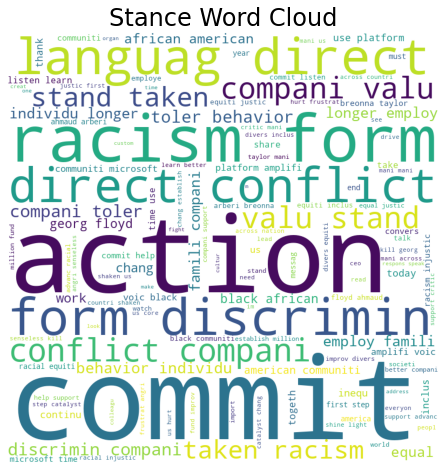

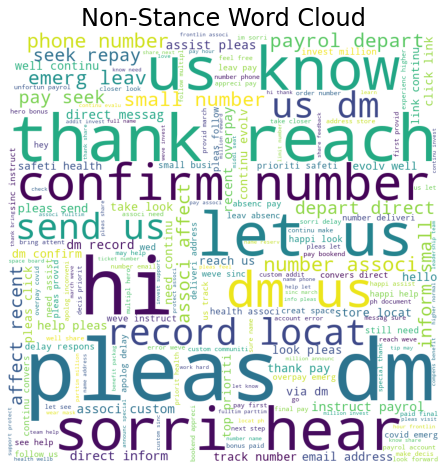

In [30]:
from nb_functions import plot_cloud

action_stems_wc = WordCloud(width = 800, height = 800, background_color ='white', 
                           random_state = 1, min_font_size = 10).generate(action_stems_str)
non_action_stems_wc = WordCloud(width = 800, height = 800, background_color ='white', 
                           random_state = 1, min_font_size = 10).generate(nonaction_stems_str)

plot_cloud(action_stems_wc, "Stance Word Cloud")
plot_cloud(non_action_stems_wc, "Non-Stance Word Cloud")


<br><br>
We also see that the average stance tweet tends to use a more neutral, objective tone than more positive, subjective nonstance tweets. These differences, though, are slightly less pronounced than those between the subsamples analyzed in the previous notebooks (e.g., high replies, high likes). 
<br><br>

In [31]:
def return_sntmt(string):
    sntmt = TextBlob(string)
    return sntmt.sentiment.polarity, sntmt.sentiment.subjectivity

print(f'The stance tweet sample polarity is {return_sntmt(action_stems_str)[0]} and subjectivity is {return_sntmt(action_stems_str)[1]}.')
print(f'The non-stance tweet sample polarity is {return_sntmt(nonaction_stems_str)[0]} and subjectivity is {return_sntmt(nonaction_stems_str)[1]}.')


The stance tweet sample polarity is 0.04488020307078123 and subjectivity is 0.36248373919680155.
The non-stance tweet sample polarity is 0.18590048176075802 and subjectivity is 0.4590364091774781.


<br><br>
Let's take a more detailed look at some of the more common bigrams for stance and non-stance tweets. In this setting, I use the Term-Frequency Inverse Document Frequency vectorizer, which multiplies the count of bigrams by the (logged) inverse frequency of the term in relation to all documents. In practice, compared to a count vectorizer, this method produces scores that heavily discount words that appear in almost all documents and thus add little to predictive power (e.g., "the", if stopwords were not removed).

We can see that bigrams with the highest TF-IDF score in the non-stance sample are mostly focused on customer service communications, with many of them focusing on either requesting more information about a customer order (e.g., record locator, confirmation number) or redirecting the conversation to a private channel (e.g., dm us, send us).

The bigrams with the highest score in the stance sample, by comparison, are directly related to race (e.g., forms discrimination, racism forms) or an appeal to company morality (e.g., values stand, family companies). Interestingly, there are a few bigrams which appear to reference individual firings at firms as well.
<br><br>

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vec_nonstance = TfidfVectorizer(ngram_range=(2,2))
tfidf_vec_stance = TfidfVectorizer(ngram_range=(2,2))

def make_df_ngram(text_col, vec, name='bigram'):
    ngrams = vec.fit_transform(text_col)
    values = ngrams.toarray().sum(axis=0)
    vocab = vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(values[i],k) for k, i in vocab.items()], reverse=True)).rename(columns={0:'score', 1:name})
    return df_ngram


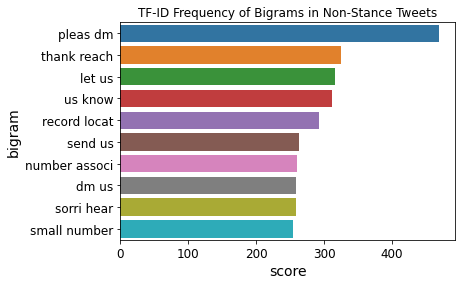

In [33]:
df_tfidf_ngram_nonstance = make_df_ngram(df['stemmed_text'][df['floyd_action']==0], tfidf_vec_nonstance)
ax = sns.barplot(x="score", y="bigram", data=df_tfidf_ngram_nonstance[:10]).set_title('TF-ID Frequency of Bigrams in Non-Stance Tweets')


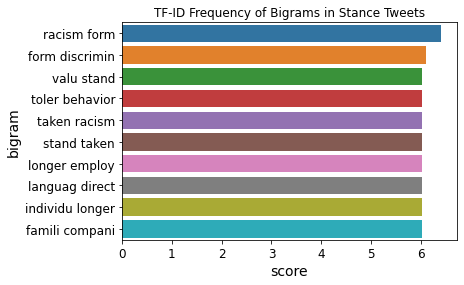

In [34]:
df_tfidf_ngram_stance = make_df_ngram(df['stemmed_text'][df['floyd_action']==1], tfidf_vec_stance)
ax = sns.barplot(x="score", y="bigram", data=df_tfidf_ngram_stance[:10]).set_title('TF-ID Frequency of Bigrams in Stance Tweets')


<br><br>
As a side note, using a Count Vectorizer (simple frequency) would yield relatively similar results. The Spearman (rank) correlations shows that these two methods are strongly correlated, with more divergence in scoring/frequency in the stance set.
<br><br>

In [35]:

ct_vec_nonstance = CountVectorizer(ngram_range=(2,2))
ct_vec_stance = CountVectorizer(ngram_range=(2,2))

df_ngram_stance = make_df_ngram(df['stemmed_text'][df['floyd_action']==1], ct_vec_stance)
df_ngram_nonstance = make_df_ngram(df['stemmed_text'][df['floyd_action']==0], ct_vec_nonstance)

df_ngram_stance.sort_values(by=['bigram'], inplace=True)
df_tfidf_ngram_stance.sort_values(by=['bigram'], inplace=True)
df_ngram_nonstance.sort_values(by=['bigram'], inplace=True)
df_tfidf_ngram_nonstance.sort_values(by=['bigram'], inplace=True)

print(f"Stance corr: {df_ngram_stance['score'].corr(df_tfidf_ngram_stance['score'], method='spearman')}")
print(f"Nonstance corr: {df_ngram_nonstance['score'].corr(df_tfidf_ngram_nonstance['score'], method='spearman')}")

# Re-sort df by most common stems for further feature engineering (See below)
df_tfidf_ngram_stance.sort_values(by=['score'], inplace=True)
df_tfidf_ngram_nonstance.sort_values(by=['score'], inplace=True)


Stance corr: 0.599474373010574
Nonstance corr: 0.7107121125266572


<br><br>
#### 2. Data Preparation

Before diving into classification algorithms, there are a few important final data preparation issues to complete. 

##### A. Correlations and Stem Tokenization/Feature Engineering

In our sample, there are a significant number of predictors, which may or may not have predictive value for a tweet being a political stance tweet.

To provide a rough sense of the predicted value of features, I create a correlation table of the numerical features in the data. There are several interesting regions of this heatmap worth exploring. For example, twitter metrics of tweet prominence (likes, replies, quotes) all seem to be highly correlated with each other. Increased CEO age is highly correlated with fewer Twitter followers and less likelihood of having tweets with media. Our target variables (*floyd stance*, *floyd_followup*) are correlated with higher twitter popularity metrics but less correlated with user popularity metrics.

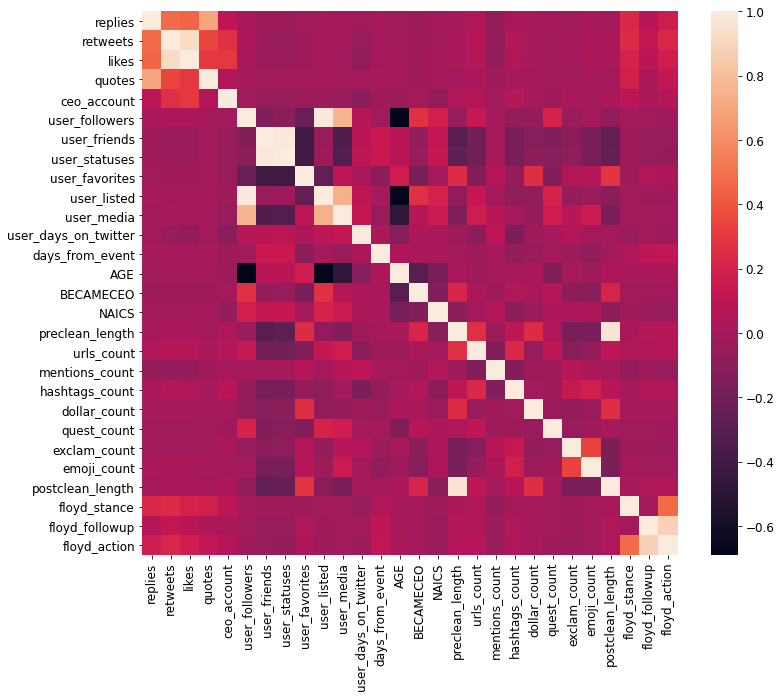

In [36]:
corr_matrix = df.corr()
plt.figure(figsize=(12,10))
corr_heat = sns.heatmap(data=corr_matrix)
plt.show()

<br><br>
At this point, I will tokenize the unigram and bigram stems using Scikit-Learn's TFIDF vectorizer. Given the large size of the dataset and to lower computational complexity, I will first create a feature that includes the 100 stems with the highest TF-IDF scores from each class for the baseline analysis. I will consider larger sets of stems (200 and 300) in a sensitivity analysis following the main results to see the degree to which ROC-AUC scores improve with larger stem sets.
<br><br>

In [37]:
def create_lst_top_n_stems(series1, series2, n_stems):
    lst1 = series1[:n_stems].to_list()
    lst2 = series2[:n_stems].to_list()
    lst1.extend(x for x in lst2 if x not in lst1)
    return lst1

stance_tfidf_vec = TfidfVectorizer(ngram_range=(1, 1))
nonstance_tfidf_vec = TfidfVectorizer(ngram_range=(1, 1))

stance_tfidf_df = make_df_ngram(df['stemmed_text'][df['floyd_action']==1], stance_tfidf_vec, name='unigram')
nonstance_tfidf_df = make_df_ngram(df['stemmed_text'][df['floyd_action']==0], nonstance_tfidf_vec, name='unigram')

In [38]:
# Create the trimmed top stems features

lst100 = create_lst_top_n_stems(stance_tfidf_df['unigram'], nonstance_tfidf_df['unigram'], 100)
df['stems_list'] = [t.split() for t in df['stemmed_text']]
df['stemmed_text_100'] = df['stems_list'].apply(lambda x: [word for word in x if word in lst100])
df['stemmed_text_100'] = [' '.join(word) for word in df['stemmed_text_100']]

lst200 = create_lst_top_n_stems(stance_tfidf_df['unigram'], nonstance_tfidf_df['unigram'], 200)
df['stemmed_text_200'] = df['stems_list'].apply(lambda x: [word for word in x if word in lst200])
df['stemmed_text_200'] = [' '.join(word) for word in df['stemmed_text_200']]

lst300 = create_lst_top_n_stems(stance_tfidf_df['unigram'], nonstance_tfidf_df['unigram'], 300)
df['stemmed_text_300'] = df['stems_list'].apply(lambda x: [word for word in x if word in lst300])
df['stemmed_text_300'] = [' '.join(word) for word in df['stemmed_text_300']]

df[['stemmed_text', 'stemmed_text_100', 'stemmed_text_200', 'stemmed_text_300']].head()

,stemmed_text,stemmed_text_100,stemmed_text_200,stemmed_text_300
0,import updat susanwojcicki youtub use platform...,use platform amplifi black voic fund black live,import use platform amplifi black voic fund bl...,import updat use platform amplifi black voic f...
1,proud googlecloud partner telefonica launch ne...,busi,proud busi,proud partner new busi
2,also excit android## make improv voic access i...,make improv voic,also make improv voic import experi,also make improv voic import experi
3,android ## avail beta focus peopl control safeti,safeti,avail peopl safeti,avail focus peopl safeti
4,today us googl youtub homepag share support ra...,today us share support racial equal black comm...,today us googl share support racial equal soli...,today us googl share support racial equal soli...


In [39]:
# Finally, let's drop features that we won't use for our analysis for being uninformative or overlapping with a 
# derivative feature (e.g., drop *date* since *days_from_event* is being used).

df_final_total = df.drop(columns=['tweet_id', 'text', 'source_label', 'username', 'compustat_company', 'date', 
                          'utc_time', 'event_date', 'user_join_date', 'EXEC_FULLNAME', 'NAICS', 'urls', 'mentions', 
                          'hashtags', 'text_clean', 'stemmed_text', 'postclean_length', 'floyd_stance', 
                          'floyd_followup', 'stems_list'])

In [40]:
df_final_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41532 entries, 0 to 41531
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   replies               41532 non-null  float64
 1   retweets              41532 non-null  float64
 2   likes                 41532 non-null  float64
 3   quotes                41532 non-null  float64
 4   media                 41532 non-null  object 
 5   ceo_account           41532 non-null  float64
 6   user_followers        41532 non-null  float64
 7   user_friends          41532 non-null  float64
 8   user_statuses         41532 non-null  float64
 9   user_favorites        41532 non-null  float64
 10  user_listed           41532 non-null  float64
 11  user_media            41532 non-null  float64
 12  user_days_on_twitter  41532 non-null  float64
 13  days_from_event       41532 non-null  float64
 14  twitter_source        41532 non-null  object 
 15  AGE                

<br><br>
##### B. Train/Test Split for Unbalanced Classes
In this dataset, the target classes (stance or no stance) are unbalanced. Naively creating a train/test split may result in observations in the minority class being limited (or absent) in either set. Below, I set a random seed for reproducibility and split the training and test sets by stratifying on the target (stance/no stance). 

Learning with imbalanced data is not a one-size-fits-all approach. I will test three resampling methods to help balance the classes in the training set:

1. Random undersampling randomly removes members of the majority class until classes are balanced. The downside is that this method throws out a large amount of data from the majority class, leading to loss of information and potentially poor model training.

2. Random oversampling randomly duplicates members of the minority class until the classes are balanced. This method has a tendency to overfit on the training data. 

3. Synthetic Minority Oversampling Technique (SMOTE): As described in detail in [this paper](https://dl.acm.org/doi/pdf/10.1145/1007730.1007735?casa_token=gBlLTeoHDFEAAAAA:LVxPdPH3Q4YMyytYvTmelTGYqVBOxL3qWpXi3-3DheV7qNqFvDMQ2IdmaGo2sZeHU3B2d1JWDLELDA), SMOTE creates synthetic minority class observations that are weighted averages of nearby (actual) minority class observation features.  

Which method is likely to perform best? The most important consideration is that we have a very small number of stance tweets (290 of ~45,000 tweets). By stratifying the train-test split, we end up with 145 minority class observations upon which we can train machine learning algorithms. Adding in, say, 5-fold cross validation lowers the number of minority class observations in each fold to the tens of data points. In this case, random undersampling may result in too few minority class observations to be of use, and may necessitate further data collection. Random oversampling may be less prone to overfitting this specific exercise, simply because stance tweets are relatively similar within class and there is a relatively clean distinction between classes. SMOTE may run into problems due to its use of nearest neighbors methods in a relatively sparse, text-heavy feature space. However, a high level of textual similarity among stance tweets might lower this concern. 

In this notebook (and previous notebooks), there is evidence that stance tweets tend to be similar in word usage and markedly different from non-stance tweets. This implies that random oversampling and SMOTE may perform slightly better than random undersampling, especially with limited data. However, I anticipate that the differences between SMOTE and random oversampling will not be too large given the data structure. Indeed, the SMOTE paper cited above notes that model performance in these settings is more often determined by a clean distinction between the majority and minority class in question rather than specific resampling techniques.

<br><br>

In [41]:
# How many stance instances do we have?
num_stances = df_final_total['floyd_action'].value_counts()[1]
print(f'There are {num_stances} stance tweets in the dataset')

There are 290 stance tweets in the dataset


In [42]:
X = df_final_total.drop(columns=['floyd_action', 'stemmed_text_200', 'stemmed_text_300'])
y = df_final_total['floyd_action']

In [43]:
# Train/test split, stratifying by class 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=1)

In [44]:
print(f"X shapes: X Train:{X_train.values.shape}, X Test:{X_test.values.shape}")
print(f"Y shapes: Y Train:{y_train.values.shape}, Y Test:{y_test.values.shape}")

X shapes: X Train:(33225, 30), X Test:(8307, 30)
Y shapes: Y Train:(33225,), Y Test:(8307,)


<br><br>
##### C. Pipeline Preprocessing and Algorithm Training


In [45]:
#Categorize features by necessary pre-processing steps and role in analysis

stdz_features = ['replies', 'retweets', 'likes', 'quotes', 'days_from_event',
                 'preclean_length', 'urls_count', 'mentions_count', 'hashtags_count', 'dollar_count', 
                 'quest_count', 'exclam_count', 'emoji_count', 'AGE', 'BECAMECEO',
                 'user_followers', 'user_friends', 'user_statuses', 'user_favorites', 
                 'user_listed', 'user_media', 'user_days_on_twitter']

one_hot_features = ['media', 'GENDER', 'CITY', 'STATE', 'NAICSDESC']
one_hot_categories = list(np.unique(df[one_hot_features].values)) # Make sure all categories are represented; test.transform() may not work o/w

tfidf_feature = 'stemmed_text_100' # Needs to be a string argument for TfidfVectorizer 


# Set up pipeline steps
Stdz = Pipeline(steps=[
    ('standardize', StandardScaler())
])

OneHot = Pipeline(steps=[
    ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))
])

Tfidf = Pipeline(steps=[
    ('tfidf_vectorize', TfidfVectorizer(ngram_range=(1,1)))
])


# Create the column transformer that preprocesses the data
features_preprocessor = ColumnTransformer(
    transformers=[
        ('Stdz', Stdz, stdz_features),
        ('OneHot', OneHot, one_hot_features),
        ('Tfidf', Tfidf, tfidf_feature),
    ],
    remainder='passthrough'
)

In [46]:
# Preprocess X_train using the features preprocessor

X_train_fin = features_preprocessor.fit_transform(X_train)
X_train_fin.toarray()

array([[-0.06215163, -0.04703721, -0.05300085, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00781699,  0.09610622,  0.05838571, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06215163, -0.06135155, -0.05806387, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.06215163, -0.06135155, -0.05806387, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06215163, -0.06135155, -0.05806387, ...,  0.        ,
         0.        ,  0.        ],
       [-0.06215163, -0.06135155, -0.05553236, ...,  0.        ,
         0.        ,  0.        ]])

#### 3. Evaluation Metrics

As previously mentioned, political stance tweets are rare events in this dataset (about 0.7% of all tweets), so our data is imbalanced by class. Relying on accuracy (true positives + true negatives over all classified outputs) may be misleading in this setting, since prospective classifiers with little predictive value-add (say, classifying all instances in the full dataset as "no stance") would yield high accuracy metrics.  

To understand potential severity of Type I and Type II errors, let's frame the business problem that a "stance classifier" would aim to resolve. Let's assume that a company uses a tweet classifier to determine when it should take a stance based on the behavior of its peers. For simplicity, let's assume there is an underlying benefit to  coordination (and cost to anti-coordination) among peers. For example, if your closest peers are going to take a stance, then you want to take a stance to avoid being labeled in the media as "not caring" about the issue. Conversely, if you take a stance while your peers fail to take a stance, then you subject yourself to sole criticism for taking an stance that may be unpopular among your stakeholders. Organizational researchers have shown that this ["wait then imitate"](https://journals.sagepub.com/doi/abs/10.2189/asqu.53.3.460?casa_token=RimO4bscEWsAAAAA:n32Tb-FI6baPzBcKgGkJKB9-Hj5A4cbJnZSnVGbndVI1_VULna0VrIiW4ztEr6eOn9w95rKiXHgErg) strategy is common among most large companies facing contentious social issues.

Let's think about classification errors and their impact on decision making in this problem. If the company's algorithm incorrectly classifies its peers' recent tweets as taking a stance (i.e., detects false positives), then a decision maker in the company who takes a stance per incorrect model recommendations risks making the company a clear target for stakeholder responses. Being a first mover in stance taking can have serious repercussions, even without faulty inference. For example, Dick's Sporting Goods was a "first mover" among hunting retailers to stop selling assault rifles in their store following the Parkland Shooting in 2018. This stance led to conservative customers boycotting the store and [at least 62 conservative employees leaving the company in protest](https://www.npr.org/2019/02/12/691999347/soul-searching-after-parkland-dicks-ceo-embraces-tougher-stance-on-guns). 

Conversely, if the company's algorithm incorrectly classifies peers' tweets as not taking a stance when they actually are (i.e., returns false negatives), then a decision maker in the company may decide not to take a stance per model recommendations. Not taking a stance on certain issues may also lead to significant stakeholder and activist pushback. For example, in mid-2020, companies from Adidas to Coca-Cola pulled ads from Facebook for failing to take a meaningful stance to limit hate speech on their site. In total, these companies represented [hundreds of millions of dollars](https://www.nytimes.com/2020/06/26/business/media/Facebook-advertising-boycott.html) in yearly advertising revenue.

In sum, unlike many situations with imbalanced classes (e.g., flagging credit fraud), Type I and Type II errors are arguably equally important without knowing more information on domain-specific aspects (e.g., company, political issue, etc.). Given the imbalance in classes, and given the roughly equal importance of Type I and Type II errors, I will put special weight on **F1** metric. F1 is the harmonic mean of precision and recall, focusing on how well we can predict the positive (stance) class. I'll also include other comparator threshold metrics (accuracy, balanced accuracy, precision, and recall).

#### 4. Model Selection 

In this section, I train a series of machine learning classifier algorithms to classify tweets as stance tweets or non-stance tweets. In order to reduce the out-of-sample variance in predictions, I use K-fold cross-validation on the transformed training data. Following empirical findings (James et al., 2013, p. 183) and the limited sample size resulting from the undersampling technique, I perform cross-validation using K=5 folds, fitting each model using data from 9 of the training folds and testing the fitted model on the held-out validation fold. Each of these models outputs a set of 10 scores, and I compute the average and standard deviation for each of these score sets. 

In [49]:
model_list = [('Logistic Regression', LogisticRegression(max_iter=1000)),
              ('CART', DecisionTreeClassifier()),
              ('Support Vector Classifier', SVC()),
              ('Random Forest', RandomForestClassifier(random_state=1, n_jobs=2)),
              ('AdaBoost', AdaBoostClassifier(random_state=1)),
              ('Gradient Boosting', GradientBoostingClassifier(random_state=1))
             ]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

resampling_techniques = [("Random Under Sampler", RandomUnderSampler(random_state=1)), 
                         ("Random Over Sampler", RandomOverSampler(random_state=1)), 
                         ("SMOTE", SMOTE(random_state=1))]

scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']

# Make a function, returns eval_list
def train_algorithms(model_list, kfold, resampling_techniques):
    index = []
    scores = {"Model": [], "Accuracy": [], "Balanced Accuracy": [], "Precision": [], "Recall": [], "F1": []}
    for techname, technique in resampling_techniques:
        for name, classifier in model_list:
            clf = make_pipeline_imb(technique, classifier)
            print(f"Training {name} with {techname}")
            cv_result = cross_validate(clf, X_train_fin, y_train, cv=kfold, scoring=scoring)
            index += [techname]
            scores["Model"].append(name)
            scores["Accuracy"].append(cv_result["test_accuracy"].mean())
            scores["Balanced Accuracy"].append(cv_result["test_balanced_accuracy"].mean())
            scores["Precision"].append(cv_result["test_precision"].mean())
            scores["Recall"].append(cv_result["test_recall"].mean())
            scores["F1"].append(cv_result["test_f1"].mean())
    df_scores = pd.DataFrame(scores, index=index)
    return df_scores

In [50]:
scoring_df = train_algorithms(model_list, kfold, resampling_techniques)
scoring_df

Training Logistic Regression with Random Under Sampler
Training CART with Random Under Sampler
Training Support Vector Classifier with Random Under Sampler
Training Random Forest with Random Under Sampler
Training AdaBoost with Random Under Sampler
Training Gradient Boosting with Random Under Sampler
Training Logistic Regression with Random Over Sampler
Training CART with Random Over Sampler
Training Support Vector Classifier with Random Over Sampler
Training Random Forest with Random Over Sampler
Training AdaBoost with Random Over Sampler
Training Gradient Boosting with Random Over Sampler
Training Logistic Regression with SMOTE
Training CART with SMOTE
Training Support Vector Classifier with SMOTE
Training Random Forest with SMOTE
Training AdaBoost with SMOTE
Training Gradient Boosting with SMOTE


,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1
Random Under Sampler,Logistic Regression,0.951693,0.964979,0.125101,0.978453,0.221545
Random Under Sampler,CART,0.939443,0.931853,0.099261,0.924142,0.178826
Random Under Sampler,Support Vector Classifier,0.913168,0.949916,0.074516,0.987186,0.138443
Random Under Sampler,Random Forest,0.942694,0.962757,0.107281,0.983104,0.193419
Random Under Sampler,AdaBoost,0.967825,0.967026,0.183749,0.966208,0.306152
Random Under Sampler,Gradient Boosting,0.955877,0.969397,0.142137,0.983104,0.246850
Random Over Sampler,Logistic Regression,0.992054,0.950961,0.466298,0.909287,0.615629
Random Over Sampler,CART,0.995064,0.805713,0.660881,0.613669,0.632364
Random Over Sampler,Support Vector Classifier,0.985854,0.937196,0.317786,0.887850,0.467601
Random Over Sampler,Random Forest,0.997412,0.836338,0.944413,0.672979,0.779361


<br><br>
This table shows wide variation across resampling technique and machine learning algorithm.

As expected, random undersampling performed significantly more poorly than our oversampling techniques, especially on precision. Thus, while the undersampling techniques were able to identify most of the stance tweets, they also misclassified a great deal of non-stance tweets as stance tweets. Precision is roughly 3x worse under this technique. The SMOTE technique, on average, yields slightly improved F1 score performance over the Random Over Sampler, especially for our Boosted Models (AdaBoost and Gradient Boost). 

Which model should we choose? This depends on the task.

1. Do we need interpretable results and are we willing to sort through false positives? From this analysis, the logistic regression showed about 90% recall using the SMOTE technique, but the results were less precise than other models. Logistic regression results are generally easier to interpret than more black-box style models, since exponentiating individual coefficients/weights on features gives us the change in odds from a one-unit change in the feature. At *very* large scale, however, there may be instances where the slightly lower performing logistic model may not be the best model for the task. 

2. Do we value models that perform best when combining both precision and recall? In this case, we may want to go with the random forest classifier, which fits individual decision trees on subsamples of our data and then averages them to avoid overfitting and improve predictive stability. This model yields among the highest mean F1 score, driven by high precision. The downsides of this model are the lower recall and that this ensemble method's workings are less interpretable than a simpler model. 

3. In practice, each model could be preferable depending on the use case. For example, the logistic regression's high recall could be useful for a company trying to see if a specific rival made a stance tweet (assuming they could filter through false positive tweets). On the other hand, if a company is looking for generic language to create their own stance tweet, a more concentrated set of "true positive" examples from the Random Forest model might give them a sense of appropriate messaging, which could be quite useful on an especially sensitive topic (like race relations).

To provide illustrative comparison of these two types of models, I'll select both the logistic and random forest models for hyperparameter tuning and testing on the test set.  

Let's start with the logistic regression model. I'll be testing regularization methods (*none, ridge*) along with various weights (*c*) on the penalty term. As a side note, I select the standard solver in SK-learn (Limited-Memory BFGS) as my preferred solver, which is a lightweight analogue to the standard Newton-Raphson method for convergence. It works well with small datasets with a relatively large number of features. The solver does not support L1 (lasso) regularization. 

From the results, the Limited-Memory BFGS with ridge (L2) regularization with C=100 yields the best score. 
<br><br>

In [51]:
# Hyperparameter Tuning of LR and RF models

from sklearn.model_selection import GridSearchCV

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

#Logistic Regression
# Grid Search
lr_clf = make_pipeline_imb(SMOTE(random_state=1), LogisticRegression(max_iter=10000))

param_grid = [
    {"logisticregression__penalty": ['none', 'l2'], 
     "logisticregression__C": [100, 10, 1.0, 0.1, 0.01, 0.0001],
    }
]

lr_grid_search = GridSearchCV(lr_clf, param_grid, n_jobs=-1, cv=kfold, scoring=scoring, error_score=0, refit='f1')
lr_grid_result = lr_grid_search.fit(X_train_fin, y_train)

# Print Results
print("Best: %f using %s" % (lr_grid_result.best_score_, lr_grid_result.best_params_))

Best: 0.712213 using {'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}


<br><br>
With a Random Forest model, the two major hyperparameters to tune are (1) the number of trees averaged in the model and (2) the maximum number of features used to determine the best leaf splits at each node. In this case, I will use a logarithmic scale for estimators (10, 100, 1000). I will use the full set of features (*auto*) and trimmed sets of features (*sqrt* of n_features and *log* of n_features). 

From the results, a Random Forest model determining best splits using the full set of features using 1000 estimators yields the best score. 
<br><br>

In [52]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

#Random Forest
# Grid Search
rf_clf = make_pipeline_imb(SMOTE(random_state=1), RandomForestClassifier(random_state=1, n_jobs=2))

param_grid = {"randomforestclassifier__n_estimators": [10, 100, 1000],
              "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2']}

rf_grid_search = GridSearchCV(rf_clf, param_grid, n_jobs=-1, cv=kfold, scoring=scoring, error_score=0, refit='f1')
rf_grid_result = rf_grid_search.fit(X_train_fin, y_train)

# Print Results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))

Best: 0.777597 using {'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 1000}


<br><br>
Finally, I test the tuned models on the test set. Below are results from both the tuned logistic model and the tuned random forest model.

Overall, the classifiers' F1 scores remain greater than 70%, with the random forest model (F1: 0.77) slightly outperforming the logistic model (F1: 0.7s). As anticipated, it appears that the managerial tradeoff of easier interpretability (logistic) versus slightly better predictive performance (random forest) still hold when choosing which model to put into production. 

Digging slightly deeper into the results by looking at the confusion matrix, we can see that the previously discussed precision/recall tradeoff (and the associated strategic considerations) remain. The logistic regression captures a higher percentage of stance tweets in its predicted positive class, but it classifies many non-stance tweets as stance tweets. On the other hand, the random forest model's predicted positive class contains a higher percentage of actual stance tweets, but it does not capture as many of the stance tweets in the positive class as the logistic regression does.  

In [53]:
from sklearn.metrics import balanced_accuracy_score

X_test_fin = features_preprocessor.transform(X_test).toarray()

model_list = [('Logistic Regression', lr_grid_result.best_estimator_),
              ('Random Forest', rf_grid_result.best_estimator_)
]

scoring = ["accuracy", "balanced_accuracy", "precision", "recall", "f1"]


# Make a function, returns eval_list
def test_models(estimator):
    final_prediction = estimator.predict(X_test_fin)
    return final_prediction

def make_test_chart(estimator_list):
    index = []
    scores = {"Accuracy": [], "Balanced Accuracy": [], "Precision": [], "Recall": [], "F1": []}
    for name, estimator in estimator_list:
        final_prediction = test_models(estimator)
        index += [name]
        scores["Accuracy"].append(accuracy_score(y_test, final_prediction))
        scores["Balanced Accuracy"].append(balanced_accuracy_score(y_test, final_prediction))
        scores["Precision"].append(precision_score(y_test, final_prediction))
        scores["Recall"].append(recall_score(y_test, final_prediction))
        scores["F1"].append(f1_score(y_test, final_prediction))
    df_scores = pd.DataFrame(scores, index=index)
    return df_scores

In [58]:
lr_final_predictions = test_models(lr_grid_result.best_estimator_)
rf_final_predictions = test_models(rf_grid_result.best_estimator_)

test_chart = make_test_chart(model_list)
test_chart
test_chart.to_pickle('../df_test_chart.pkl', protocol=4)

In [55]:
lr_matrix = confusion_matrix(y_test, lr_final_predictions) 
rf_matrix = confusion_matrix(y_test, rf_final_predictions)

print(f"Logistic Model Confusion Matrix:\n{lr_matrix}")
print("   ")
print(f"Random Forest Model Confusion Matrix:\n{rf_matrix}")

Logistic Model Confusion Matrix:
[[8219   30]
 [   8   50]]
   
Random Forest Model Confusion Matrix:
[[8246    3]
 [  20   38]]


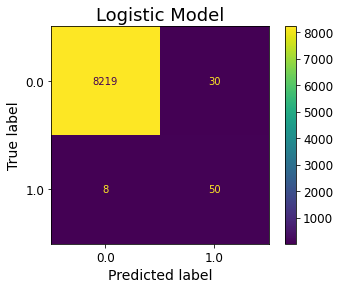

In [59]:
plot_confusion_matrix(lr_grid_result.best_estimator_, X_test_fin, y_test)  
plt.title("Logistic Model", fontsize=18)
plt.savefig("../conf_matrix_lr.png")
plt.show()

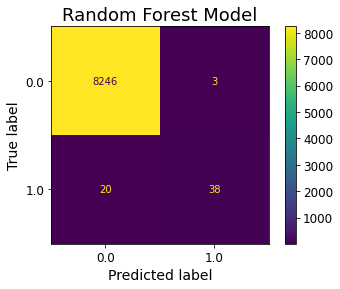

In [60]:
plot_confusion_matrix(rf_grid_result.best_estimator_, X_test_fin, y_test)  
plt.title("Random Forest Model", fontsize=18)
plt.savefig("../conf_matrix_rf.png")
plt.show() 